In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from lib import algos, helpers, envs
from lib.helpers import np_exclude
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [19]:
def plot_policy_chain(Q, Q_star=None, zeta=None, policy_name='NONE'):
    nS, nA = Q.shape
    grid_size=(1,nS)
    S_terminal = [nS-1]

    data = []
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            s = row * grid_size[1] + col
            data.append([col, row])
    data = pd.DataFrame(data, columns=['x', 'y'])

    annot = ['$s_{}$'.format(i) for i in range(1,1+nS)]

    plt.figure(figsize=(nS-1,0.6))
    plt.scatter(data['x'], data['y'], s=250, facecolors='none', edgecolors='k')
    plt.axis('off')
    plt.xlim(-0.25, nS-0.75)
    plt.ylim(-0.6, 0.6)

    for i, txt in enumerate(annot):
        plt.gca().annotate(txt, (data['x'][i], data['y'][i]), ha='center', va='center')


    data = []
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            s = row * grid_size[1] + col
            if s in S_terminal:
                data.append([col, row, 0, 'none'])
            else:
                if Q_star is None: # plot deterministic greedy policy
                    data.append([col, row, Q[s].argmax(), 'k'])
                else: # plot near-optimal policy
                    try:
                        Q_cutoff = (1-zeta) * Q_star[s].max()
                        Q_tilde_s_a = Q[s][Q[s] > Q_cutoff].min()
                        for a in range(nA):
                            if Q[s,a] == Q[s].max(): # best best action
                                data.append([col, row, a, 'k'])
                            elif Q[s,a] == Q_tilde_s_a: # worst best action
                                data.append([col, row, a, 'r'])
                            elif Q[s,a] >= Q_cutoff: # Pi_a = list(np.argwhere(Q[s] > Q_cutoff)[:,0])
                                data.append([col, row, a, 'grey'])
                            else:
                                pass
                    except: # fall back on greedy policy
                        data.append([col, row, Q[s].argmax(), 'green'])

    data = pd.DataFrame(data, columns=['x', 'y', 'a', 'color'])

    style="Simple,tail_width=0.2,head_width=3,head_length=5"
    kw = dict(arrowstyle=style, color="k")
    directions = {
        0: -.5,
        1: -.2,
        2: .2,
        3: .5,
    }
    offset = 0.125
    offsets = {
        0: offset,
        1: 0,
        2: 0,
        3: -offset,
    }
    inactive_alpha = 0.125
    for s in range(nS-1):
        a = patches.FancyArrowPatch((s+offset, 0), (s+1 - offset, 0),connectionstyle="arc3,rad=-.2", alpha=inactive_alpha, **kw)
        plt.gca().add_patch(a)
        a = patches.FancyArrowPatch((s+offset, 0+offset), (s+1 - offset,0 +offset),connectionstyle="arc3,rad=-.5", alpha=inactive_alpha, **kw)
        plt.gca().add_patch(a)
        a = patches.FancyArrowPatch((s+offset, 0), (s+1 - offset, 0),connectionstyle="arc3,rad=.2", alpha=inactive_alpha, **kw)
        plt.gca().add_patch(a)
        a = patches.FancyArrowPatch((s+offset, 0-offset), (s+1 - offset,0 -offset),connectionstyle="arc3,rad=.5", alpha=inactive_alpha, **kw)
        plt.gca().add_patch(a)

    for i, row in data.iterrows():
        s = row['x']
        if s == nS-1:
            continue
        a = row['a']
        arrow = patches.FancyArrowPatch((s+offset, 0+offsets[a]), (s+1 - offset, 0+offsets[a]),connectionstyle="arc3,rad={}".format(directions[a]), **kw)
        plt.gca().add_patch(arrow)

#     plt.tight_layout()
    plt.savefig('figures/_chain_{}_{}_zeta_{}.pdf'.format(nS, policy_name, zeta), bbox_inches='tight', pad_inches=0)
    
    pi_worst = algos.zeta_optimal_worst_case_policy(Q, dict(Q_star=Q_star, zeta=zeta))
    V_pi_worst = algos.policy_eval(env, pi_worst, gamma=gamma)
    plt.text(4.25, 0, '({:.1%})'.format(
        (np_exclude(V_pi_worst, S_terminal) / np_exclude(V_star, S_terminal)).min()
    ), fontsize=12, ha='left', va='center')
    
    plt.savefig('figures/chain_{}_{}_zeta_{}.pdf'.format(nS, policy_name, zeta), bbox_inches='tight', pad_inches=0)
    plt.show()

# Start.

In [7]:
# Define environment
np.random.seed(42)
env = envs.Chain(5,4)
nS, nA = env.nS, env.nA
S_terminal = env.S_terminal

n_ep = 2000
epsilon = 0.9
alpha_max, alpha_min, alpha_decay = 0.9, 1e-10, 1e-3
alpha = lambda ep: alpha_min + (alpha_max-alpha_min)*np.exp(-alpha_decay*(ep//100))
# alpha = 0.1
gamma = 0.9

## Run Q-learning

In [5]:
Q_star, metadata = algos.qlearn(
    env, n_ep, algos.epsilon_greedy_policy, 
    gamma=gamma, alpha=alpha, epsilon=epsilon,
    save_Q=1,
)
V_star = Q_star.max(axis=1)

100%|██████████| 2000/2000 [00:01<00:00, 1053.02it/s]


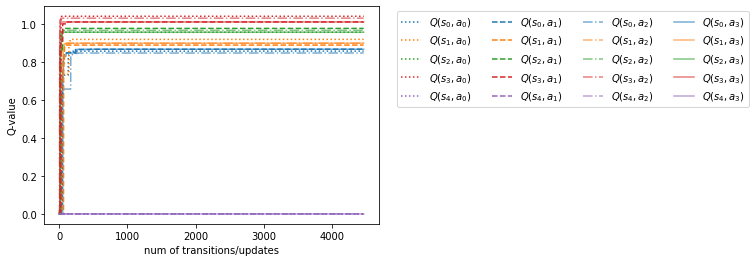

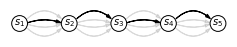

array([[0.85656, 0.86656, 0.84656, 0.86656],
       [0.9184 , 0.8884 , 0.8984 , 0.8984 ],
       [0.956  , 0.976  , 0.966  , 0.956  ],
       [1.04   , 1.01   , 1.03   , 1.01   ],
       [0.     , 0.     , 0.     , 0.     ]])

In [6]:
helpers.plot_Q_learning_curves(metadata['Qs'])
plot_policy_chain(Q_star, Q_star, zeta=0)
Q_star

## Run near-greedy TD

zeta: 0.0


100%|██████████| 4465/4465 [00:00<00:00, 13315.61it/s]


Q
[[0.85656 0.86656 0.84656 0.86656]
 [0.9184  0.8884  0.8984  0.8984 ]
 [0.956   0.976   0.966   0.956  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.86656 0.9184  0.976   1.04    0.     ]
Policy near-optimality (policy eval): 1.0


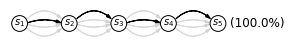

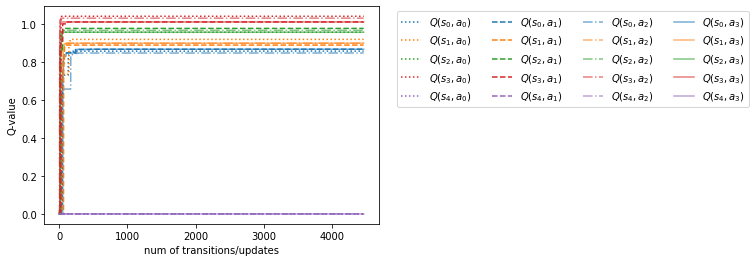

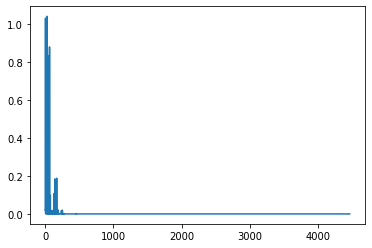

zeta: 0.01


100%|██████████| 4465/4465 [00:00<00:00, 12133.47it/s]


Q
[[0.84927 0.85927 0.83927 0.85927]
 [0.9103  0.8803  0.8903  0.8903 ]
 [0.947   0.967   0.957   0.947  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.85927 0.9103  0.967   1.03    0.     ]
Policy near-optimality (policy eval): 0.9903846153846154


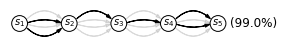

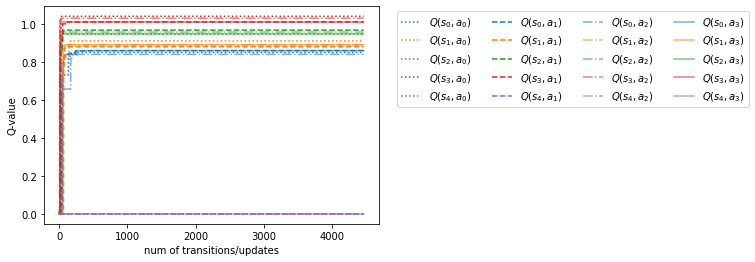

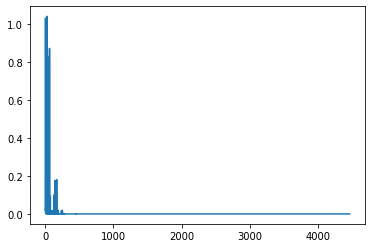

zeta: 0.02


100%|██████████| 4465/4465 [00:00<00:00, 13323.29it/s]


Q
[[0.84117 0.85117 0.83117 0.85117]
 [0.9013  0.8713  0.8813  0.8813 ]
 [0.947   0.967   0.957   0.947  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.85117 0.9013  0.957   1.03    0.     ]
Policy near-optimality (policy eval): 0.9805327868852459


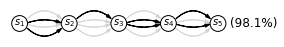

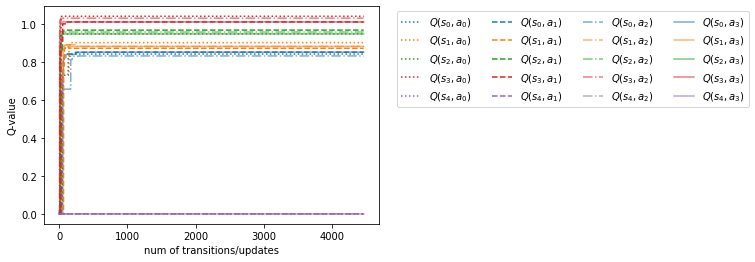

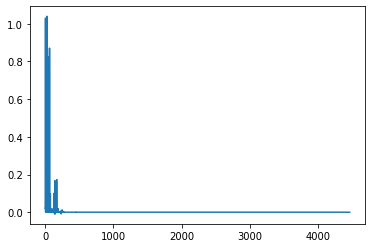

zeta: 0.05


100%|██████████| 4465/4465 [00:00<00:00, 17446.46it/s]


Q
[[0.81849 0.82849 0.80849 0.82849]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.82849 0.8761  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9518442622950819


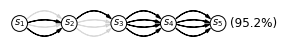

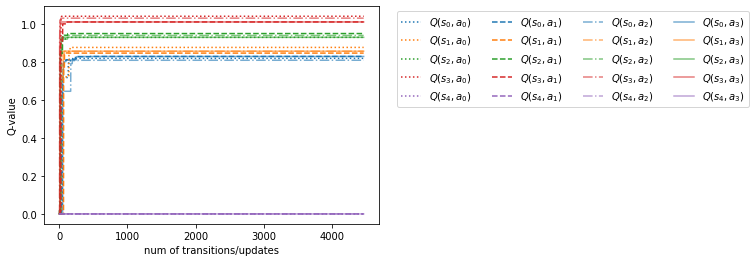

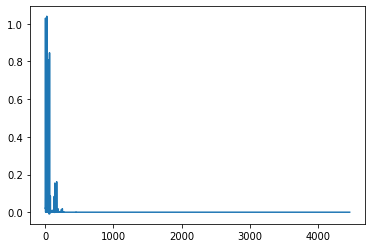

zeta: 0.1


100%|██████████| 4465/4465 [00:00<00:00, 13824.25it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


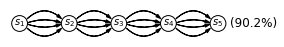

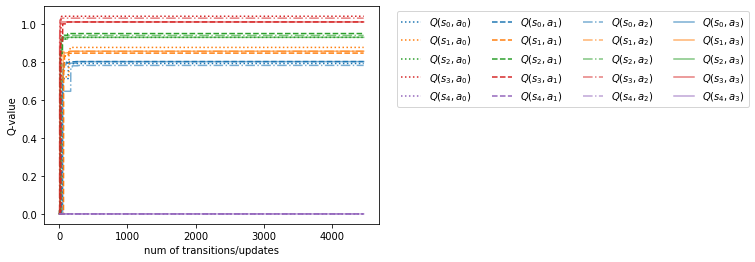

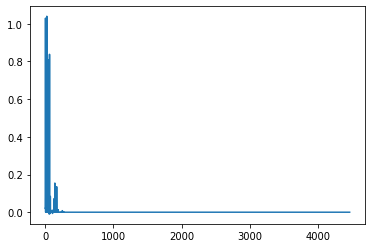

zeta: 0.2


100%|██████████| 4465/4465 [00:00<00:00, 13208.15it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


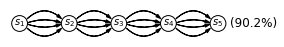

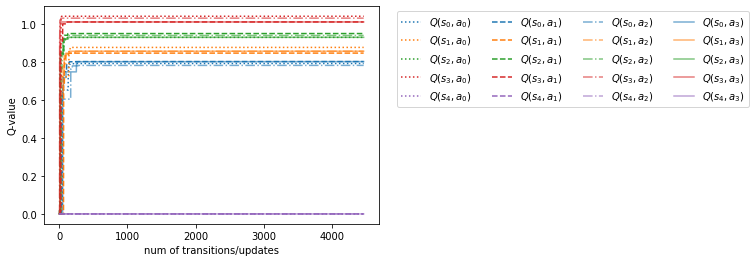

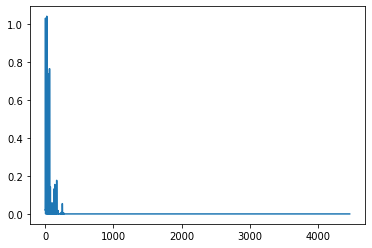

zeta: 0.3


100%|██████████| 4465/4465 [00:00<00:00, 13703.48it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


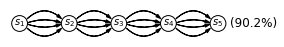

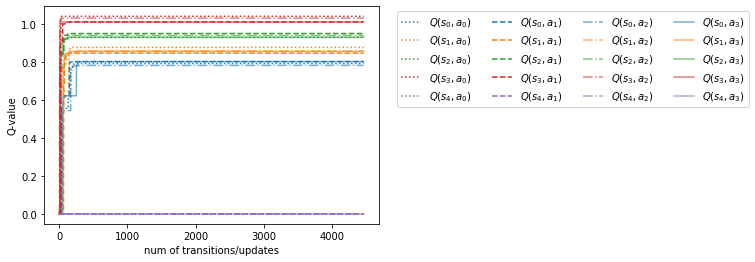

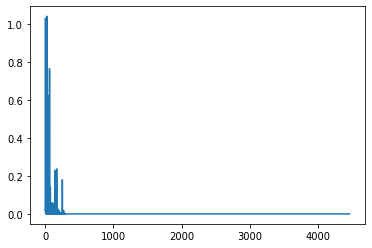

zeta: 0.4


100%|██████████| 4465/4465 [00:00<00:00, 13199.41it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


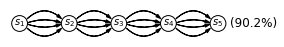

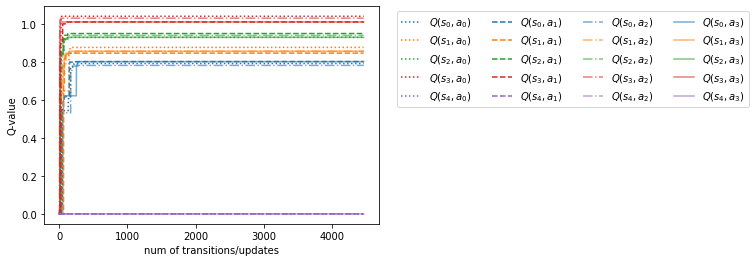

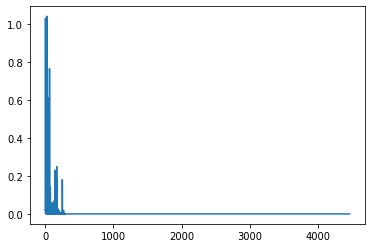

zeta: 0.5


100%|██████████| 4465/4465 [00:00<00:00, 12524.66it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


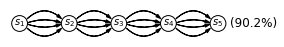

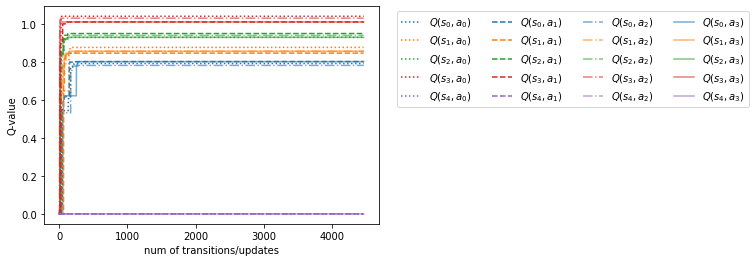

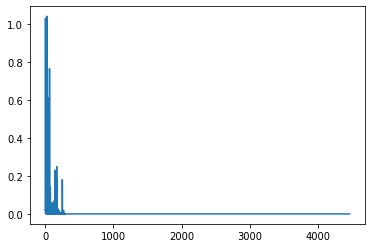

zeta: 1.0


100%|██████████| 4465/4465 [00:00<00:00, 12468.66it/s]


Q
[[0.79149 0.80149 0.78149 0.80149]
 [0.8761  0.8461  0.8561  0.8561 ]
 [0.929   0.949   0.939   0.929  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.78149 0.8461  0.929   1.01    0.     ]
Policy near-optimality (policy eval): 0.9018302252584934


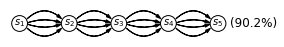

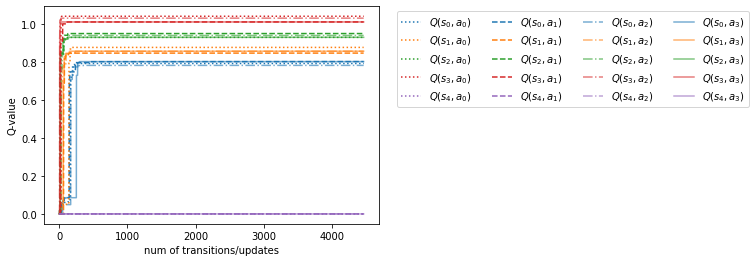

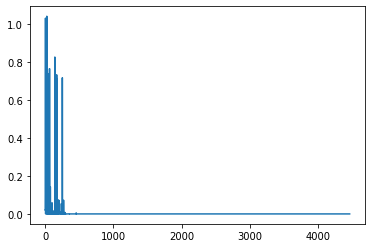

In [20]:
for zeta in [0.00, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
    print('='*80)
    print('zeta:', zeta, flush=True)
    Q, metadata1 = algos.TD_near_greedy(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha, 
        Q_star=Q_star, memory=metadata['memory'],
        save_Q=1,
    )
    helpers.display_results(Q, Q_star, zeta, 1e-10)

    pi = algos.zeta_optimal_worst_case_policy(Q, dict(Q_star=Q_star, zeta=zeta))
    V_pi = algos.policy_eval(env, pi, gamma=gamma)
    print(
        'Policy near-optimality (policy eval):', 
        (np_exclude(V_pi, S_terminal) / np_exclude(V_star, S_terminal)).min()
    )

    plot_policy_chain(Q, Q_star, zeta, 'near-greedy')
    helpers.plot_Q_learning_curves(metadata1['Qs'])
    plt.plot(metadata1['TD_errors'])
    plt.show()

## Run TD conservative

zeta: 0.0


100%|██████████| 4465/4465 [00:00<00:00, 26438.15it/s]

Q
[[0.85656 0.86656 0.84656 0.86656]
 [0.9184  0.8884  0.8984  0.8984 ]
 [0.956   0.976   0.966   0.956  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.86656 0.9184  0.976   1.04    0.     ]
Policy near-optimality (policy eval): 1.0


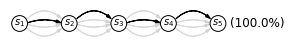

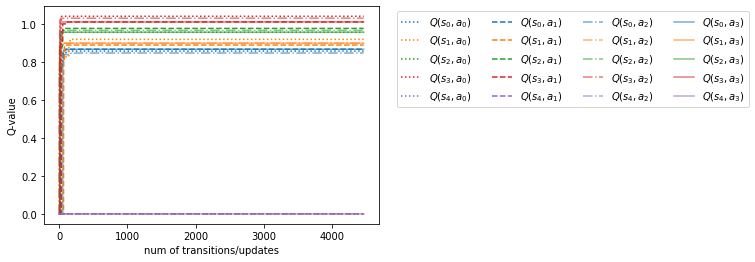

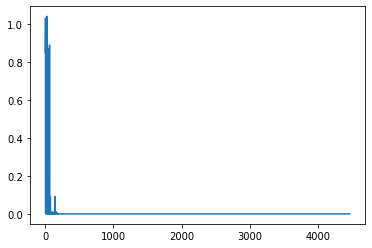

zeta: 0.01


100%|██████████| 4465/4465 [00:00<00:00, 26826.29it/s]

Q
[[0.8482944 0.8582944 0.8382944 0.8582944]
 [0.909616  0.879616  0.889616  0.889616 ]
 [0.94664   0.96664   0.95664   0.94664  ]
 [1.04      1.01      1.03      1.01     ]
 [0.        0.        0.        0.       ]]
V
[0.8582944 0.909616  0.96664   1.03      0.       ]
Policy near-optimality (policy eval): 0.9903846153846154


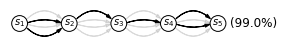

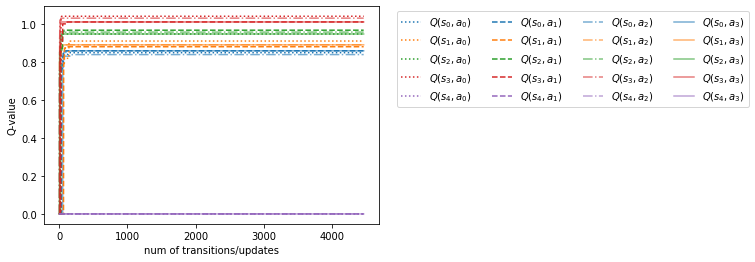

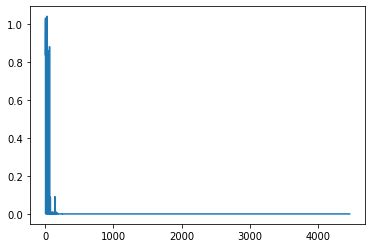

zeta: 0.02


100%|██████████| 4465/4465 [00:00<00:00, 26443.00it/s]

Q
[[0.8400288 0.8500288 0.8300288 0.8500288]
 [0.900832  0.870832  0.880832  0.880832 ]
 [0.93728   0.95728   0.94728   0.93728  ]
 [1.04      1.01      1.03      1.01     ]
 [0.        0.        0.        0.       ]]
V
[0.8500288 0.900832  0.95728   1.03      0.       ]
Policy near-optimality (policy eval): 0.9903846153846154


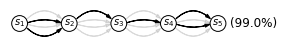

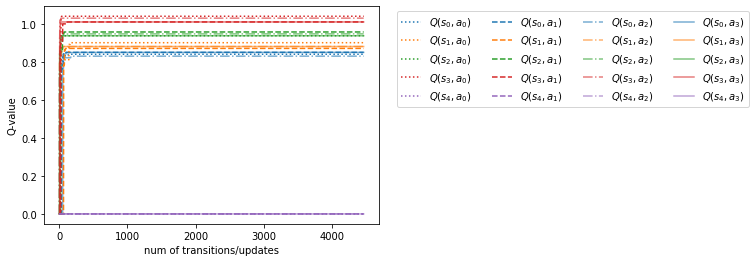

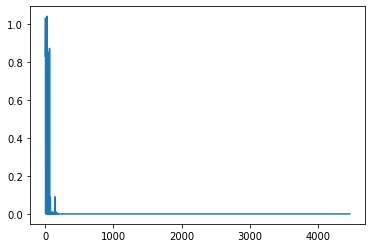

zeta: 0.05


100%|██████████| 4465/4465 [00:00<00:00, 34557.55it/s]

Q
[[0.815232 0.825232 0.805232 0.825232]
 [0.87448  0.84448  0.85448  0.85448 ]
 [0.9092   0.9292   0.9192   0.9092  ]
 [1.04     1.01     1.03     1.01    ]
 [0.       0.       0.       0.      ]]
V
[0.825232 0.87448  0.9292   1.01     0.      ]
Policy near-optimality (policy eval): 0.9711538461538461


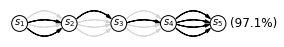

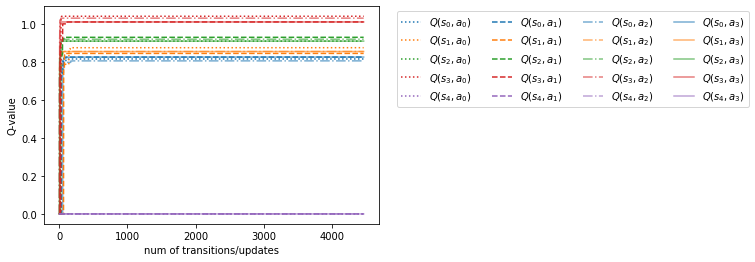

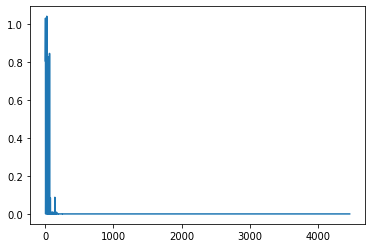

zeta: 0.1


100%|██████████| 4465/4465 [00:00<00:00, 25982.65it/s]

Q
[[0.773904 0.783904 0.763904 0.783904]
 [0.83056  0.80056  0.81056  0.81056 ]
 [0.8624   0.8824   0.8724   0.8624  ]
 [1.04     1.01     1.03     1.01    ]
 [0.       0.       0.       0.      ]]
V
[0.783904 0.83056  0.8824   1.01     0.      ]
Policy near-optimality (policy eval): 0.9711538461538461


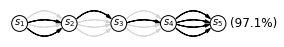

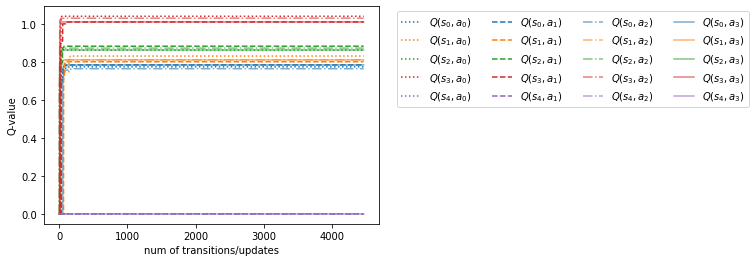

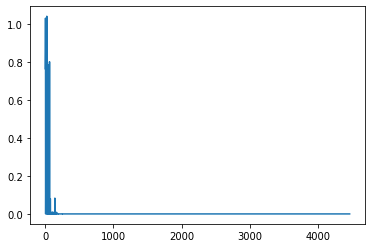

zeta: 0.2


100%|██████████| 4465/4465 [00:00<00:00, 26514.73it/s]

Q
[[0.691248 0.701248 0.681248 0.701248]
 [0.74272  0.71272  0.72272  0.72272 ]
 [0.7688   0.7888   0.7788   0.7688  ]
 [1.04     1.01     1.03     1.01    ]
 [0.       0.       0.       0.      ]]
V
[0.701248 0.74272  0.7888   1.01     0.      ]
Policy near-optimality (policy eval): 0.9711538461538461


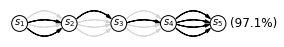

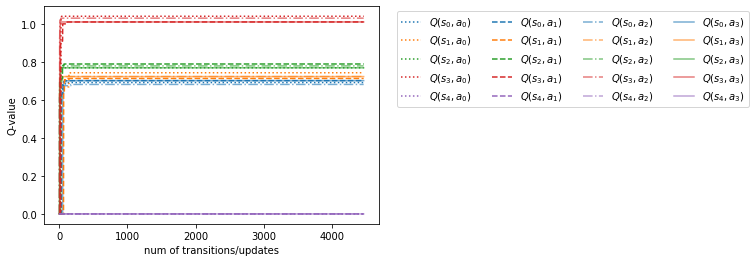

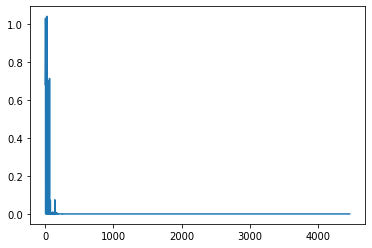

zeta: 0.3


100%|██████████| 4465/4465 [00:00<00:00, 26707.50it/s]

Q
[[0.608592 0.618592 0.598592 0.618592]
 [0.65488  0.62488  0.63488  0.63488 ]
 [0.6752   0.6952   0.6852   0.6752  ]
 [1.04     1.01     1.03     1.01    ]
 [0.       0.       0.       0.      ]]
V
[0.608592 0.65488  0.6852   1.01     0.      ]
Policy near-optimality (policy eval): 0.9538750923190548


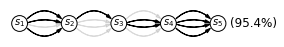

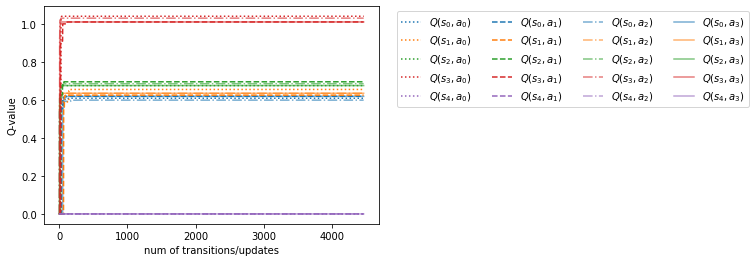

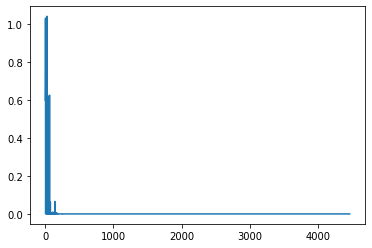

zeta: 0.4


100%|██████████| 4465/4465 [00:00<00:00, 27050.02it/s]

Q
[[0.525936 0.535936 0.515936 0.535936]
 [0.56704  0.53704  0.54704  0.54704 ]
 [0.5816   0.6016   0.5916   0.5816  ]
 [1.04     1.01     1.03     1.01    ]
 [0.       0.       0.       0.      ]]
V
[0.525936 0.56704  0.5916   1.01     0.      ]
Policy near-optimality (policy eval): 0.9538750923190548


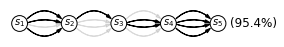

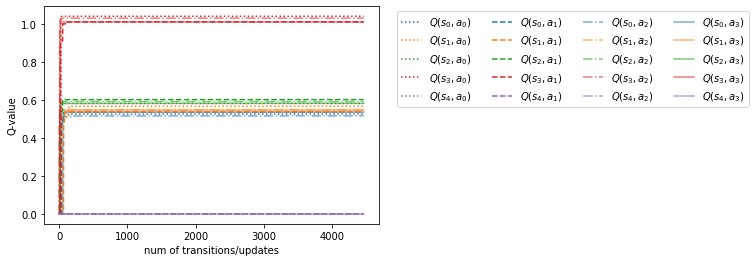

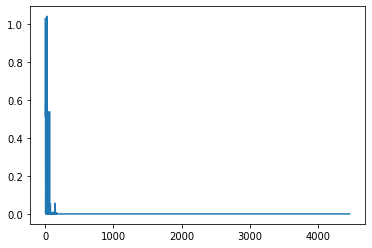

zeta: 0.5


100%|██████████| 4465/4465 [00:00<00:00, 49572.42it/s]

Q
[[0.44328 0.45328 0.43328 0.45328]
 [0.4792  0.4492  0.4592  0.4592 ]
 [0.488   0.508   0.498   0.488  ]
 [1.04    1.01    1.03    1.01   ]
 [0.      0.      0.      0.     ]]
V
[0.43328 0.4592  0.488   1.01    0.     ]
Policy near-optimality (policy eval): 0.9122161189069424


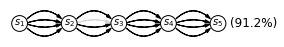

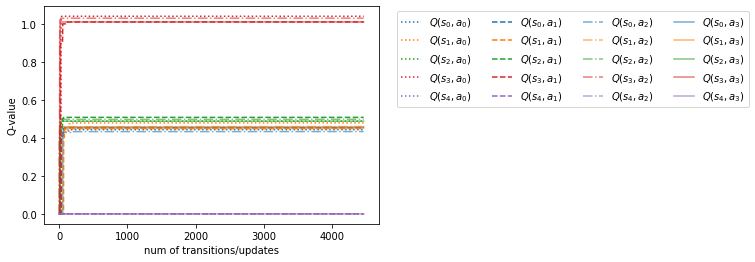

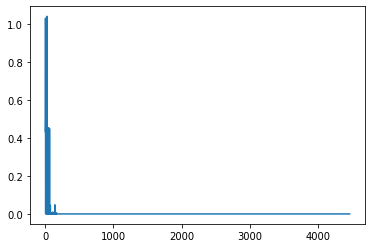

zeta: 1.0


100%|██████████| 4465/4465 [00:00<00:00, 27645.27it/s]

Q
[[0.03 0.04 0.02 0.04]
 [0.04 0.01 0.02 0.02]
 [0.02 0.04 0.03 0.02]
 [1.04 1.01 1.03 1.01]
 [0.   0.   0.   0.  ]]
V
[0.02 0.01 0.02 1.01 0.  ]
Policy near-optimality (policy eval): 0.9018302252584934


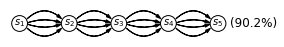

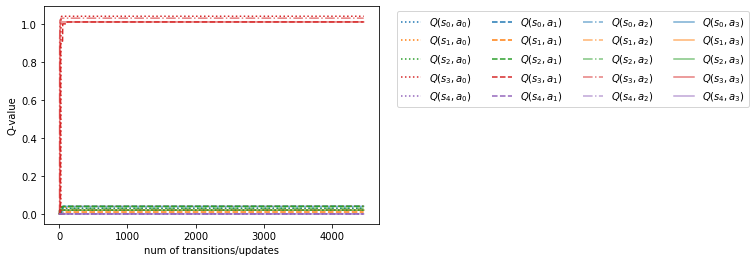

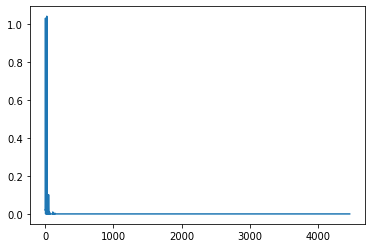

In [21]:
for zeta in [0.00, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
    print('='*80)
    print('zeta:', zeta, flush=True)
    Q, metadata1 = algos.TD_conservative(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha, 
        Q_star=Q_star, memory=metadata['memory'],
        save_Q=1,
    )
    helpers.display_results(Q, Q_star, zeta, 1e-10)
    
    pi = algos.zeta_optimal_worst_case_policy(Q, dict(Q_star=Q_star, zeta=zeta))
    V_pi = algos.policy_eval(env, pi, gamma=gamma)
    print(
        'Policy near-optimality (policy eval):', 
        (np_exclude(V_pi, S_terminal) / np_exclude(V_star, S_terminal)).min()
    )
    
    plot_policy_chain(Q, Q_star, zeta, 'conservative')
    helpers.plot_Q_learning_curves(metadata1['Qs'])
    plt.plot(metadata1['TD_errors'])
    plt.show()